In [1]:
import numpy as np
from models.vgg import vgg16_bn
from models.densenet import densenet121
from ECANET.eca_resnet import eca_resnet50
from models.seNet import se_resnet50
from LR_Scheduler.WarmupScheluder import WarmUpLR
from Utils.View import visualize_network, init_weights, split_weights, visualize_lastlayer, visualize_train_loss, visualize_test_loss, visualize_learning_rate, visualize_param_hist, visualize_test_acc
from tensorboardX import SummaryWriter
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import ImageFolder
from tqdm import tqdm
import seaborn as sns
from jupyterthemes import jtplot
jtplot.style(theme='onedork')

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

writer = SummaryWriter(log_dir="D:\\Resource\\logs_5_ECA-Net50\\")

EPOCH = 150
pre_epoch = 0
BATCH_SIZE = 64
LR = 0.1984
accumulation_steps = 8

transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

transform_validation = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

In [11]:
train = ImageFolder('C:\\dataset\\Ovarian_After_Split\\', transform=transform_train)
validate = ImageFolder('C:\\dataset\\Validation\\', transform=transform_validation)
trainloader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True, num_workers=16, pin_memory=True)
validation_loader = torch.utils.data.DataLoader(validate, batch_size= BATCH_SIZE, shuffle=True,num_workers=16, pin_memory=True)

In [12]:
len(trainloader.sampler)

32648

In [13]:
# net = mpncovresnet50(n_classes=2)
# net = resnet50(n_classes=2)
net = se_resnet50(num_classes=2)
init_weights(net)
net = nn.DataParallel(net)
net.to(device)
criterion = nn.CrossEntropyLoss()
parameters = split_weights(net)
optimizer = optim.SGD(parameters, lr=LR, weight_decay=1e-4, momentum=0.9, nesterov=True)
warmup_sl = WarmUpLR(optimizer, len(trainloader) * 5)
schedular = torch.optim.lr_scheduler.MultiStepLR(optimizer,  milestones=[25, 35, 45, 65, 80, 100, 130], gamma=0.7)

In [14]:
visualize_network(writer, net.module)

In [15]:
# net.load_state_dict(torch.load('D:\Resource\models\model_best.pth'))

In [16]:
total_loss = []
total_acc = []
total_val_loss = []
total_val_acc = []

In [17]:
# total_loss = list(np.load('D:\Resource\modelEvaluation\\loss_6.npy'))
# total_acc = list(np.load('D:\Resource\modelEvaluation\\acc_6.npy'))
# total_val_loss = list(np.load('D:\Resource\modelEvaluation\\val_loss_6.npy'))
# total_val_acc = list(np.load('D:\Resource\modelEvaluation\\val_acc_6.npy'))
best_acc = 0.0

In [18]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


In [19]:
for epoch in range(pre_epoch, EPOCH):
    net.train()
    train_loss = AverageMeter()
    validation_loss = AverageMeter()
    sum_loss = 0.0
    total = 0.0
    correct = 0.0
    val_total = 0.0
    val_correct = 0.0
    val_final_loss = 0.0
    update = 0
    i = 0

    if epoch > 5:
            schedular.step(epoch)

    with tqdm(trainloader, unit="batch") as t_epoch:

        for images, labels in t_epoch:
            if epoch <= 5:
                warmup_sl.step()


            t_epoch.set_description(f"Epoch {epoch+1}")

            length = len(trainloader)
            images, labels = images.to(device), labels.to(device)

            # optimizer.zero_grad()

            output = net(images)


            loss = criterion(output, labels)
            train_loss.update(loss.item(), images.size(0))

            loss.backward()

            if (i+1) % accumulation_steps == 0:
                # optimizer the net
                update += 1
                optimizer.step()        # update parameters of net
                optimizer.zero_grad()


            # optimizer.step()


            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += predicted.eq(labels.data).sum()

            n_iter = (epoch - 1) * len(trainloader) + i + 1

            t_epoch.set_postfix(loss='{:.4f}'.format(train_loss.val),loss_avg='{:.4f}'.format(train_loss.avg) ,accuracy='{:.3f}'.format(100. * correct / total), learning_rate=optimizer.state_dict()['param_groups'][0]['lr'],update=update)

            visualize_lastlayer(writer, net, n_iter)
            visualize_train_loss(writer, loss.item(), n_iter)

            i += 1

        total_loss.append(train_loss.avg)
        total_acc.append(100. * correct / total)

        visualize_learning_rate(writer, optimizer.param_groups[0]['lr'], epoch)
        visualize_param_hist(writer, net, epoch)

        # schedular.step()

        with torch.no_grad():

            net.eval()
            i = 0
            with tqdm(validation_loader, unit='batch') as v_epoch:

                for test, test_labels in v_epoch:


                    v_epoch.set_description(f"Epoch {epoch+1}")

                    test, test_labels = test.to(device), test_labels.to(device)
                    out = net(test)
                    test_loss = criterion(out, test_labels)
                    validation_loss.update(test_loss.item(), test.size(0))

                    _, pre = torch.max(out.data, 1)
                    val_total += test_labels.size(0)
                    val_correct += pre.eq(test_labels.data).sum()
                    v_epoch.set_postfix(val_loss='{:.4f}'.format(validation_loss.val), val_loss_avg='{:.4f}'.format(validation_loss.avg), val_accuracy='{:.3f}'.format(100. * val_correct / val_total), update=update)


            total_val_acc.append(100. * val_correct / val_total)
            total_val_loss.append(validation_loss.avg)
            visualize_test_loss(writer, total_val_loss[-1], epoch)
            visualize_test_acc(writer, total_val_acc[-1], epoch)
            try:
                if len(total_val_loss) < 2:
                    print("val_acc_avg: {}, val_loss_avg: {}".format(total_val_acc[-1], total_val_loss[-1]))
                    continue
                if total_val_acc[-1] > best_acc:
                    best_acc = total_val_acc[-1]
                    torch.save(net.state_dict(), 'D:\Resource\models\model_best_ECA-Net50.pth')
                    print("Save Best Model: val_acc_avg: {}, val_loss_avg: {}".format(total_val_acc[-1], total_val_loss[-1]))

                else:
                    print("val_acc_avg: {}, val_loss_avg: {}".format(total_val_acc[-1], total_val_loss[-1]))



            except Exception:
                print("Error")
                continue




  0%|          | 0/511 [00:00<?, ?batch/s]E:\anaconda\envs\deeplearning\lib\site-packages\torch\optim\lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
Epoch 1: 100%|██████████| 171/171 [00:45<00:00,  3.73batch/s, update=63, val_accuracy=57.894, val_loss=0.7319, val_loss_avg=0.6811]


val_acc_avg: 57.893768310546875, val_loss_avg: 0.6811371796206941


Epoch 2: 100%|██████████| 171/171 [00:46<00:00,  3.65batch/s, update=63, val_accuracy=49.495, val_loss=0.5300, val_loss_avg=0.7068]


Save Best Model: val_acc_avg: 49.49457931518555, val_loss_avg: 0.7068211380073941


Epoch 3: 100%|██████████| 171/171 [00:47<00:00,  3.63batch/s, update=63, val_accuracy=57.260, val_loss=0.7247, val_loss_avg=0.7086]


Save Best Model: val_acc_avg: 57.25969314575195, val_loss_avg: 0.7086345347997086


Epoch 4: 100%|██████████| 171/171 [00:46<00:00,  3.67batch/s, update=63, val_accuracy=50.368, val_loss=0.5872, val_loss_avg=0.7383]


val_acc_avg: 50.36758041381836, val_loss_avg: 0.7383464596942382


Epoch 5: 100%|██████████| 171/171 [00:46<00:00,  3.69batch/s, update=63, val_accuracy=55.817, val_loss=0.5910, val_loss_avg=0.6936]


val_acc_avg: 55.81694412231445, val_loss_avg: 0.6935570741527946


Epoch 6: 100%|██████████| 171/171 [00:46<00:00,  3.70batch/s, update=63, val_accuracy=53.556, val_loss=0.7116, val_loss_avg=0.7076]
E:\anaconda\envs\deeplearning\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


val_acc_avg: 53.556331634521484, val_loss_avg: 0.7075672018858817


Epoch 7: 100%|██████████| 171/171 [00:46<00:00,  3.67batch/s, update=63, val_accuracy=57.480, val_loss=0.7382, val_loss_avg=0.7208]


Save Best Model: val_acc_avg: 57.48024368286133, val_loss_avg: 0.7207793370916264


Epoch 8: 100%|██████████| 171/171 [00:46<00:00,  3.70batch/s, update=63, val_accuracy=60.614, val_loss=0.8651, val_loss_avg=0.6585]


Save Best Model: val_acc_avg: 60.61385726928711, val_loss_avg: 0.6584812184726243


Epoch 9: 100%|██████████| 171/171 [00:47<00:00,  3.62batch/s, update=63, val_accuracy=61.156, val_loss=0.6213, val_loss_avg=0.6502]


Save Best Model: val_acc_avg: 61.156036376953125, val_loss_avg: 0.6501712204011743


Epoch 10: 100%|██████████| 171/171 [00:46<00:00,  3.69batch/s, update=63, val_accuracy=62.406, val_loss=0.6563, val_loss_avg=0.6394]


Save Best Model: val_acc_avg: 62.40580749511719, val_loss_avg: 0.6393710008068046


Epoch 11: 100%|██████████| 171/171 [00:46<00:00,  3.65batch/s, update=63, val_accuracy=62.369, val_loss=0.4888, val_loss_avg=0.6425]


val_acc_avg: 62.369049072265625, val_loss_avg: 0.642492630117585


Epoch 12: 100%|██████████| 171/171 [00:46<00:00,  3.67batch/s, update=63, val_accuracy=61.588, val_loss=0.6298, val_loss_avg=0.6605]


val_acc_avg: 61.58794403076172, val_loss_avg: 0.6605183140711407


Epoch 13: 100%|██████████| 171/171 [00:46<00:00,  3.69batch/s, update=63, val_accuracy=64.464, val_loss=0.2020, val_loss_avg=0.6180]


Save Best Model: val_acc_avg: 64.4642562866211, val_loss_avg: 0.618003707434561


Epoch 14: 100%|██████████| 171/171 [00:46<00:00,  3.70batch/s, update=63, val_accuracy=64.740, val_loss=1.1176, val_loss_avg=0.6198]


Save Best Model: val_acc_avg: 64.73993682861328, val_loss_avg: 0.6198452530352426


Epoch 15: 100%|██████████| 171/171 [00:46<00:00,  3.67batch/s, update=63, val_accuracy=63.950, val_loss=0.4945, val_loss_avg=0.6297]


val_acc_avg: 63.949642181396484, val_loss_avg: 0.6296814712196824


Epoch 16: 100%|██████████| 171/171 [00:46<00:00,  3.70batch/s, update=63, val_accuracy=67.708, val_loss=0.7336, val_loss_avg=0.5849]


Save Best Model: val_acc_avg: 67.70814514160156, val_loss_avg: 0.5849191499992101


Epoch 17: 100%|██████████| 171/171 [00:46<00:00,  3.67batch/s, update=63, val_accuracy=64.988, val_loss=0.5477, val_loss_avg=0.6058]


val_acc_avg: 64.98805236816406, val_loss_avg: 0.6057672266836575


Epoch 18: 100%|██████████| 171/171 [00:46<00:00,  3.70batch/s, update=63, val_accuracy=63.178, val_loss=0.3846, val_loss_avg=0.6274]


val_acc_avg: 63.1777229309082, val_loss_avg: 0.6273741687982973


Epoch 19: 100%|██████████| 171/171 [00:46<00:00,  3.69batch/s, update=63, val_accuracy=70.290, val_loss=0.7259, val_loss_avg=0.5672]


Save Best Model: val_acc_avg: 70.29039001464844, val_loss_avg: 0.5672331283776512


Epoch 20: 100%|██████████| 171/171 [00:46<00:00,  3.68batch/s, update=63, val_accuracy=69.142, val_loss=0.6891, val_loss_avg=0.5814]


val_acc_avg: 69.1417007446289, val_loss_avg: 0.5814173976806699


Epoch 21: 100%|██████████| 171/171 [00:46<00:00,  3.70batch/s, update=63, val_accuracy=72.395, val_loss=0.3336, val_loss_avg=0.5252]


Save Best Model: val_acc_avg: 72.39478302001953, val_loss_avg: 0.5252047712323946


Epoch 22: 100%|██████████| 171/171 [00:46<00:00,  3.64batch/s, update=63, val_accuracy=72.965, val_loss=0.9974, val_loss_avg=0.5260]


Save Best Model: val_acc_avg: 72.96453094482422, val_loss_avg: 0.5260037361337647


Epoch 23: 100%|██████████| 171/171 [00:46<00:00,  3.66batch/s, update=63, val_accuracy=73.792, val_loss=0.3695, val_loss_avg=0.5034]


Save Best Model: val_acc_avg: 73.79158020019531, val_loss_avg: 0.5034401861266428


Epoch 24: 100%|██████████| 171/171 [00:46<00:00,  3.68batch/s, update=63, val_accuracy=65.925, val_loss=0.7618, val_loss_avg=0.6196]


val_acc_avg: 65.92538452148438, val_loss_avg: 0.6195575485464362


Epoch 25: 100%|██████████| 171/171 [00:46<00:00,  3.68batch/s, update=63, val_accuracy=71.954, val_loss=0.7001, val_loss_avg=0.5948]


val_acc_avg: 71.95368194580078, val_loss_avg: 0.5948187131759898


Epoch 26: 100%|██████████| 171/171 [00:46<00:00,  3.64batch/s, update=63, val_accuracy=76.751, val_loss=0.5910, val_loss_avg=0.4649]


Save Best Model: val_acc_avg: 76.75059509277344, val_loss_avg: 0.46493407354878935


Epoch 27: 100%|██████████| 171/171 [00:46<00:00,  3.66batch/s, update=63, val_accuracy=68.912, val_loss=2.0545, val_loss_avg=0.7565]


val_acc_avg: 68.9119644165039, val_loss_avg: 0.7564956903063271


Epoch 28: 100%|██████████| 171/171 [00:46<00:00,  3.70batch/s, update=63, val_accuracy=77.137, val_loss=0.6249, val_loss_avg=0.4517]


Save Best Model: val_acc_avg: 77.13655853271484, val_loss_avg: 0.4516722849243114


Epoch 29: 100%|██████████| 171/171 [00:46<00:00,  3.68batch/s, update=63, val_accuracy=77.945, val_loss=0.1197, val_loss_avg=0.4489]


Save Best Model: val_acc_avg: 77.94522857666016, val_loss_avg: 0.44888626249632707


Epoch 30: 100%|██████████| 171/171 [00:46<00:00,  3.67batch/s, update=63, val_accuracy=70.548, val_loss=1.3016, val_loss_avg=0.5492]


val_acc_avg: 70.54769134521484, val_loss_avg: 0.5491735493297678


Epoch 31: 100%|██████████| 171/171 [00:46<00:00,  3.69batch/s, update=63, val_accuracy=72.441, val_loss=0.9157, val_loss_avg=0.5910]


val_acc_avg: 72.44072723388672, val_loss_avg: 0.5909806117702989


Epoch 32: 100%|██████████| 171/171 [00:45<00:00,  3.72batch/s, update=63, val_accuracy=79.213, val_loss=0.8294, val_loss_avg=0.4367]


Save Best Model: val_acc_avg: 79.21337890625, val_loss_avg: 0.43665075389761804


Epoch 33: 100%|██████████| 171/171 [00:46<00:00,  3.66batch/s, update=63, val_accuracy=69.574, val_loss=0.3604, val_loss_avg=0.5977]


val_acc_avg: 69.5736083984375, val_loss_avg: 0.5976599748137681


Epoch 34: 100%|██████████| 171/171 [00:46<00:00,  3.70batch/s, update=63, val_accuracy=79.388, val_loss=0.0155, val_loss_avg=0.4376]


Save Best Model: val_acc_avg: 79.38797760009766, val_loss_avg: 0.4376011900593501


Epoch 35: 100%|██████████| 171/171 [00:46<00:00,  3.67batch/s, update=63, val_accuracy=81.042, val_loss=0.2438, val_loss_avg=0.3985]


Save Best Model: val_acc_avg: 81.04208374023438, val_loss_avg: 0.39853098628670386


Epoch 36: 100%|██████████| 171/171 [00:43<00:00,  3.89batch/s, update=63, val_accuracy=81.042, val_loss=1.0985, val_loss_avg=0.3911]


val_acc_avg: 81.04208374023438, val_loss_avg: 0.3910778918000754


Epoch 37: 100%|██████████| 171/171 [00:43<00:00,  3.89batch/s, update=63, val_accuracy=80.950, val_loss=0.2636, val_loss_avg=0.4081]


val_acc_avg: 80.9501953125, val_loss_avg: 0.4081231440566213


Epoch 38: 100%|██████████| 171/171 [00:44<00:00,  3.87batch/s, update=63, val_accuracy=79.250, val_loss=0.1006, val_loss_avg=0.4249]


val_acc_avg: 79.25013732910156, val_loss_avg: 0.4249190297761706


Epoch 39: 100%|██████████| 171/171 [00:43<00:00,  3.93batch/s, update=63, val_accuracy=81.713, val_loss=0.1972, val_loss_avg=0.3856]


Save Best Model: val_acc_avg: 81.71292114257812, val_loss_avg: 0.3855974029594212


Epoch 40: 100%|██████████| 171/171 [00:44<00:00,  3.85batch/s, update=63, val_accuracy=74.858, val_loss=1.4451, val_loss_avg=0.5272]


val_acc_avg: 74.85755920410156, val_loss_avg: 0.5272182753541368


Epoch 41: 100%|██████████| 171/171 [00:44<00:00,  3.88batch/s, update=63, val_accuracy=80.739, val_loss=0.0163, val_loss_avg=0.4213]


val_acc_avg: 80.73883056640625, val_loss_avg: 0.42125922169668495


Epoch 42: 100%|██████████| 171/171 [00:43<00:00,  3.95batch/s, update=63, val_accuracy=79.131, val_loss=0.0890, val_loss_avg=0.4186]


val_acc_avg: 79.13067626953125, val_loss_avg: 0.418640382975433


Epoch 43: 100%|██████████| 171/171 [00:44<00:00,  3.88batch/s, update=63, val_accuracy=80.243, val_loss=0.0807, val_loss_avg=0.4219]


val_acc_avg: 80.24259948730469, val_loss_avg: 0.42190818025076177


Epoch 44: 100%|██████████| 171/171 [00:43<00:00,  3.90batch/s, update=63, val_accuracy=82.283, val_loss=0.0430, val_loss_avg=0.3828]


Save Best Model: val_acc_avg: 82.28266906738281, val_loss_avg: 0.38278478020868895


Epoch 45: 100%|██████████| 171/171 [00:44<00:00,  3.86batch/s, update=63, val_accuracy=83.110, val_loss=0.0361, val_loss_avg=0.3672]


Save Best Model: val_acc_avg: 83.1097183227539, val_loss_avg: 0.3672319357549579


Epoch 46: 100%|██████████| 171/171 [00:44<00:00,  3.81batch/s, update=63, val_accuracy=70.879, val_loss=2.5021, val_loss_avg=0.8213]


val_acc_avg: 70.8785171508789, val_loss_avg: 0.8213298108248649


Epoch 47: 100%|██████████| 171/171 [00:43<00:00,  3.91batch/s, update=63, val_accuracy=83.202, val_loss=0.0453, val_loss_avg=0.3619]


Save Best Model: val_acc_avg: 83.20161437988281, val_loss_avg: 0.36187060838306767


Epoch 48: 100%|██████████| 171/171 [00:44<00:00,  3.84batch/s, update=63, val_accuracy=85.407, val_loss=1.0598, val_loss_avg=0.3180]


Save Best Model: val_acc_avg: 85.40709686279297, val_loss_avg: 0.3180062860234041


Epoch 49: 100%|██████████| 171/171 [00:43<00:00,  3.90batch/s, update=63, val_accuracy=85.269, val_loss=0.1357, val_loss_avg=0.3248]


val_acc_avg: 85.26924896240234, val_loss_avg: 0.32483535326375085


Epoch 50: 100%|██████████| 171/171 [00:43<00:00,  3.93batch/s, update=63, val_accuracy=82.742, val_loss=0.7565, val_loss_avg=0.3738]


val_acc_avg: 82.74214172363281, val_loss_avg: 0.37381032461454883


Epoch 51: 100%|██████████| 171/171 [00:44<00:00,  3.89batch/s, update=63, val_accuracy=81.033, val_loss=0.0390, val_loss_avg=0.4220]


val_acc_avg: 81.03289794921875, val_loss_avg: 0.4220228943904628


Epoch 52: 100%|██████████| 171/171 [00:43<00:00,  3.89batch/s, update=63, val_accuracy=82.623, val_loss=0.3518, val_loss_avg=0.3727]


val_acc_avg: 82.6226806640625, val_loss_avg: 0.37265048680925955


Epoch 53: 100%|██████████| 171/171 [00:43<00:00,  3.90batch/s, update=63, val_accuracy=86.675, val_loss=0.0262, val_loss_avg=0.3008]


Save Best Model: val_acc_avg: 86.67523956298828, val_loss_avg: 0.30082535731149684


Epoch 54: 100%|██████████| 171/171 [00:44<00:00,  3.87batch/s, update=63, val_accuracy=84.589, val_loss=0.0230, val_loss_avg=0.3402]


val_acc_avg: 84.58922576904297, val_loss_avg: 0.3401834375018408


Epoch 55: 100%|██████████| 171/171 [00:44<00:00,  3.86batch/s, update=63, val_accuracy=87.208, val_loss=0.5661, val_loss_avg=0.2976]


Save Best Model: val_acc_avg: 87.20823669433594, val_loss_avg: 0.2976090951869427


Epoch 56: 100%|██████████| 171/171 [00:43<00:00,  3.89batch/s, update=63, val_accuracy=84.314, val_loss=0.2446, val_loss_avg=0.3484]


val_acc_avg: 84.31354522705078, val_loss_avg: 0.34844624322196005


Epoch 57: 100%|██████████| 171/171 [00:43<00:00,  3.89batch/s, update=63, val_accuracy=83.753, val_loss=0.1376, val_loss_avg=0.3519]


val_acc_avg: 83.75298309326172, val_loss_avg: 0.35192938505551585


Epoch 58: 100%|██████████| 171/171 [00:43<00:00,  3.95batch/s, update=63, val_accuracy=83.845, val_loss=0.0344, val_loss_avg=0.3568]


val_acc_avg: 83.84487915039062, val_loss_avg: 0.35676847199315953


Epoch 59: 100%|██████████| 171/171 [00:44<00:00,  3.88batch/s, update=63, val_accuracy=81.740, val_loss=1.5641, val_loss_avg=0.4044]


val_acc_avg: 81.74048614501953, val_loss_avg: 0.4044162845199675


Epoch 60: 100%|██████████| 171/171 [00:44<00:00,  3.87batch/s, update=63, val_accuracy=81.364, val_loss=0.1112, val_loss_avg=0.4254]


val_acc_avg: 81.36371612548828, val_loss_avg: 0.4253867886737304


Epoch 61: 100%|██████████| 171/171 [00:43<00:00,  3.95batch/s, update=63, val_accuracy=84.075, val_loss=0.0099, val_loss_avg=0.3680]


val_acc_avg: 84.07461547851562, val_loss_avg: 0.3680281262491169


Epoch 62: 100%|██████████| 171/171 [00:43<00:00,  3.93batch/s, update=63, val_accuracy=86.335, val_loss=0.0958, val_loss_avg=0.3040]


val_acc_avg: 86.33523559570312, val_loss_avg: 0.3039636063147963


Epoch 63: 100%|██████████| 171/171 [00:44<00:00,  3.87batch/s, update=63, val_accuracy=86.841, val_loss=0.0350, val_loss_avg=0.3045]


val_acc_avg: 86.84065246582031, val_loss_avg: 0.30454508091195215


Epoch 64: 100%|██████████| 171/171 [00:44<00:00,  3.88batch/s, update=63, val_accuracy=87.732, val_loss=0.0054, val_loss_avg=0.2836]


Save Best Model: val_acc_avg: 87.7320327758789, val_loss_avg: 0.2836316412829473


Epoch 65: 100%|██████████| 171/171 [00:43<00:00,  3.92batch/s, update=63, val_accuracy=86.262, val_loss=0.0147, val_loss_avg=0.3212]


val_acc_avg: 86.26171875, val_loss_avg: 0.32116091298221844


Epoch 66: 100%|██████████| 171/171 [00:44<00:00,  3.87batch/s, update=63, val_accuracy=85.343, val_loss=0.0423, val_loss_avg=0.3638]


val_acc_avg: 85.34276580810547, val_loss_avg: 0.36384717177786585


Epoch 67: 100%|██████████| 171/171 [00:44<00:00,  3.87batch/s, update=63, val_accuracy=87.760, val_loss=0.3891, val_loss_avg=0.2792]


Save Best Model: val_acc_avg: 87.75960540771484, val_loss_avg: 0.27918787348513613


Epoch 68: 100%|██████████| 171/171 [00:43<00:00,  3.90batch/s, update=63, val_accuracy=88.587, val_loss=0.4650, val_loss_avg=0.2755]


Save Best Model: val_acc_avg: 88.58665466308594, val_loss_avg: 0.2754630789535928


Epoch 69: 100%|██████████| 171/171 [00:44<00:00,  3.86batch/s, update=63, val_accuracy=87.080, val_loss=0.0870, val_loss_avg=0.3091]


val_acc_avg: 87.07958221435547, val_loss_avg: 0.30909042141987897


Epoch 70: 100%|██████████| 171/171 [00:43<00:00,  3.89batch/s, update=63, val_accuracy=81.639, val_loss=0.0101, val_loss_avg=0.4398]


val_acc_avg: 81.639404296875, val_loss_avg: 0.43975461321422293


Epoch 71: 100%|██████████| 171/171 [00:44<00:00,  3.87batch/s, update=63, val_accuracy=87.236, val_loss=0.1032, val_loss_avg=0.2971]


val_acc_avg: 87.23580169677734, val_loss_avg: 0.2971423172231567


Epoch 72: 100%|██████████| 171/171 [00:43<00:00,  3.93batch/s, update=63, val_accuracy=89.643, val_loss=0.0031, val_loss_avg=0.2418]


Save Best Model: val_acc_avg: 89.64344787597656, val_loss_avg: 0.24179099258456493


Epoch 73: 100%|██████████| 171/171 [00:44<00:00,  3.85batch/s, update=63, val_accuracy=87.714, val_loss=0.0674, val_loss_avg=0.2902]


val_acc_avg: 87.71365356445312, val_loss_avg: 0.29022209103510366


Epoch 74: 100%|██████████| 171/171 [00:43<00:00,  3.93batch/s, update=63, val_accuracy=86.730, val_loss=0.0086, val_loss_avg=0.3203]


val_acc_avg: 86.73037719726562, val_loss_avg: 0.32026362860637964


Epoch 75: 100%|██████████| 171/171 [00:44<00:00,  3.86batch/s, update=63, val_accuracy=87.833, val_loss=0.3542, val_loss_avg=0.2890]


val_acc_avg: 87.83311462402344, val_loss_avg: 0.2889544147709848


Epoch 76: 100%|██████████| 171/171 [00:44<00:00,  3.86batch/s, update=63, val_accuracy=89.450, val_loss=0.0959, val_loss_avg=0.2458]


val_acc_avg: 89.45046997070312, val_loss_avg: 0.24579001081557292


Epoch 77: 100%|██████████| 171/171 [00:44<00:00,  3.88batch/s, update=63, val_accuracy=89.790, val_loss=0.0695, val_loss_avg=0.2474]


Save Best Model: val_acc_avg: 89.79048156738281, val_loss_avg: 0.24739979767849768


Epoch 78: 100%|██████████| 171/171 [00:44<00:00,  3.88batch/s, update=63, val_accuracy=88.486, val_loss=0.0380, val_loss_avg=0.2748]


val_acc_avg: 88.4855728149414, val_loss_avg: 0.27483947973844214


Epoch 79: 100%|██████████| 171/171 [00:43<00:00,  3.91batch/s, update=63, val_accuracy=87.649, val_loss=0.1262, val_loss_avg=0.2981]


val_acc_avg: 87.64933013916016, val_loss_avg: 0.2980803434785467


Epoch 80: 100%|██████████| 171/171 [00:45<00:00,  3.74batch/s, update=63, val_accuracy=78.010, val_loss=0.0258, val_loss_avg=0.5792]


val_acc_avg: 78.00955963134766, val_loss_avg: 0.5791642749618737


Epoch 81: 100%|██████████| 171/171 [00:44<00:00,  3.85batch/s, update=63, val_accuracy=90.360, val_loss=0.0481, val_loss_avg=0.2317]


Save Best Model: val_acc_avg: 90.3602294921875, val_loss_avg: 0.2316994157549082


Epoch 82: 100%|██████████| 171/171 [00:44<00:00,  3.87batch/s, update=63, val_accuracy=89.478, val_loss=1.0472, val_loss_avg=0.2551]


val_acc_avg: 89.47803497314453, val_loss_avg: 0.2551254390947215


Epoch 83: 100%|██████████| 171/171 [00:43<00:00,  3.91batch/s, update=63, val_accuracy=90.811, val_loss=0.0000, val_loss_avg=0.2280]


Save Best Model: val_acc_avg: 90.81050872802734, val_loss_avg: 0.22797581421445837


Epoch 84: 100%|██████████| 171/171 [00:44<00:00,  3.88batch/s, update=63, val_accuracy=90.103, val_loss=0.0089, val_loss_avg=0.2420]


val_acc_avg: 90.10292053222656, val_loss_avg: 0.24201422998128108


Epoch 85: 100%|██████████| 171/171 [00:43<00:00,  3.91batch/s, update=63, val_accuracy=89.745, val_loss=0.0047, val_loss_avg=0.2376]


val_acc_avg: 89.7445297241211, val_loss_avg: 0.23756973628119726


Epoch 86: 100%|██████████| 171/171 [00:43<00:00,  3.93batch/s, update=63, val_accuracy=92.106, val_loss=0.0000, val_loss_avg=0.1969]


Save Best Model: val_acc_avg: 92.10623168945312, val_loss_avg: 0.19694515959214368


Epoch 87: 100%|██████████| 171/171 [00:43<00:00,  3.89batch/s, update=63, val_accuracy=90.461, val_loss=0.0458, val_loss_avg=0.2323]


val_acc_avg: 90.46131134033203, val_loss_avg: 0.23231907292277557


Epoch 88: 100%|██████████| 171/171 [00:44<00:00,  3.88batch/s, update=63, val_accuracy=91.141, val_loss=0.0164, val_loss_avg=0.2250]


val_acc_avg: 91.1413345336914, val_loss_avg: 0.2250489895659085


Epoch 89: 100%|██████████| 171/171 [00:44<00:00,  3.88batch/s, update=63, val_accuracy=91.160, val_loss=0.1694, val_loss_avg=0.2149]


val_acc_avg: 91.15971374511719, val_loss_avg: 0.21488513850241192


Epoch 90: 100%|██████████| 171/171 [00:44<00:00,  3.87batch/s, update=63, val_accuracy=92.244, val_loss=0.0144, val_loss_avg=0.2005]


Save Best Model: val_acc_avg: 92.24407196044922, val_loss_avg: 0.20052345229086493


Epoch 91: 100%|██████████| 171/171 [00:43<00:00,  3.89batch/s, update=63, val_accuracy=91.546, val_loss=0.0007, val_loss_avg=0.2190]


val_acc_avg: 91.54566955566406, val_loss_avg: 0.2189781205154105


Epoch 92: 100%|██████████| 171/171 [00:44<00:00,  3.88batch/s, update=63, val_accuracy=89.074, val_loss=0.0541, val_loss_avg=0.2803]


val_acc_avg: 89.07369995117188, val_loss_avg: 0.28028661065643007


Epoch 93: 100%|██████████| 171/171 [00:43<00:00,  3.90batch/s, update=63, val_accuracy=90.507, val_loss=0.0095, val_loss_avg=0.2470]


val_acc_avg: 90.50725555419922, val_loss_avg: 0.24697009426813954


Epoch 94: 100%|██████████| 171/171 [00:43<00:00,  3.92batch/s, update=63, val_accuracy=90.103, val_loss=0.0206, val_loss_avg=0.2510]


val_acc_avg: 90.10292053222656, val_loss_avg: 0.2509569086400086


Epoch 95: 100%|██████████| 171/171 [00:43<00:00,  3.89batch/s, update=63, val_accuracy=91.536, val_loss=0.0011, val_loss_avg=0.2144]


val_acc_avg: 91.53648376464844, val_loss_avg: 0.2143669460574781


Epoch 96: 100%|██████████| 171/171 [00:45<00:00,  3.73batch/s, update=63, val_accuracy=90.360, val_loss=0.0074, val_loss_avg=0.2476]


val_acc_avg: 90.3602294921875, val_loss_avg: 0.24764769618854576


Epoch 97: 100%|██████████| 171/171 [00:43<00:00,  3.89batch/s, update=63, val_accuracy=91.389, val_loss=0.0083, val_loss_avg=0.2194]


val_acc_avg: 91.38945007324219, val_loss_avg: 0.219441603331049


Epoch 98: 100%|██████████| 171/171 [00:44<00:00,  3.88batch/s, update=63, val_accuracy=87.236, val_loss=0.4064, val_loss_avg=0.3162]


val_acc_avg: 87.23580169677734, val_loss_avg: 0.31621192550970295


Epoch 99: 100%|██████████| 171/171 [00:43<00:00,  3.93batch/s, update=63, val_accuracy=90.406, val_loss=0.2046, val_loss_avg=0.2466]


val_acc_avg: 90.40617370605469, val_loss_avg: 0.24664723331427404


Epoch 100: 100%|██████████| 171/171 [00:44<00:00,  3.88batch/s, update=63, val_accuracy=91.307, val_loss=0.7227, val_loss_avg=0.2304]


val_acc_avg: 91.30674743652344, val_loss_avg: 0.2303591175917163


Epoch 101: 100%|██████████| 171/171 [00:44<00:00,  3.84batch/s, update=63, val_accuracy=90.783, val_loss=0.0002, val_loss_avg=0.2452]


val_acc_avg: 90.78294372558594, val_loss_avg: 0.24520178847893903


Epoch 102: 100%|██████████| 171/171 [00:43<00:00,  3.94batch/s, update=63, val_accuracy=87.953, val_loss=0.0018, val_loss_avg=0.3021]


val_acc_avg: 87.95258331298828, val_loss_avg: 0.3021382097712391


Epoch 103: 100%|██████████| 171/171 [00:44<00:00,  3.88batch/s, update=63, val_accuracy=93.264, val_loss=0.0000, val_loss_avg=0.1770]


Save Best Model: val_acc_avg: 93.26410675048828, val_loss_avg: 0.17704228950844775


Epoch 104: 100%|██████████| 171/171 [00:43<00:00,  3.89batch/s, update=63, val_accuracy=90.305, val_loss=0.1056, val_loss_avg=0.2610]


val_acc_avg: 90.30509185791016, val_loss_avg: 0.26098673614459184


Epoch 105: 100%|██████████| 171/171 [00:44<00:00,  3.85batch/s, update=63, val_accuracy=89.754, val_loss=0.2803, val_loss_avg=0.2818]


val_acc_avg: 89.75372314453125, val_loss_avg: 0.2817951059203401


Epoch 106: 100%|██████████| 171/171 [00:44<00:00,  3.82batch/s, update=63, val_accuracy=92.042, val_loss=0.4023, val_loss_avg=0.2137]


val_acc_avg: 92.04190063476562, val_loss_avg: 0.2137249565983362


Epoch 107: 100%|██████████| 171/171 [00:44<00:00,  3.87batch/s, update=63, val_accuracy=92.161, val_loss=0.0038, val_loss_avg=0.2140]


val_acc_avg: 92.16136932373047, val_loss_avg: 0.21395664361706582


Epoch 108: 100%|██████████| 171/171 [00:44<00:00,  3.89batch/s, update=63, val_accuracy=90.176, val_loss=0.0029, val_loss_avg=0.2820]


val_acc_avg: 90.17643737792969, val_loss_avg: 0.2819872664767298


Epoch 109: 100%|██████████| 171/171 [00:44<00:00,  3.87batch/s, update=63, val_accuracy=92.878, val_loss=0.0001, val_loss_avg=0.1825]


val_acc_avg: 92.87814331054688, val_loss_avg: 0.1825151795425118


Epoch 110: 100%|██████████| 171/171 [00:44<00:00,  3.84batch/s, update=63, val_accuracy=90.755, val_loss=0.0123, val_loss_avg=0.2397]


val_acc_avg: 90.75537872314453, val_loss_avg: 0.2396769554216803


Epoch 111: 100%|██████████| 171/171 [00:43<00:00,  3.92batch/s, update=63, val_accuracy=92.759, val_loss=1.3733, val_loss_avg=0.1915]


val_acc_avg: 92.75868225097656, val_loss_avg: 0.19153454756828775


Epoch 112: 100%|██████████| 171/171 [00:43<00:00,  3.91batch/s, update=63, val_accuracy=93.200, val_loss=0.0135, val_loss_avg=0.1911]


val_acc_avg: 93.19977569580078, val_loss_avg: 0.1911253352009172


Epoch 113: 100%|██████████| 171/171 [00:44<00:00,  3.87batch/s, update=63, val_accuracy=93.191, val_loss=0.0255, val_loss_avg=0.1807]


val_acc_avg: 93.19058990478516, val_loss_avg: 0.18067117370158417


Epoch 114: 100%|██████████| 171/171 [00:44<00:00,  3.85batch/s, update=63, val_accuracy=92.685, val_loss=0.0088, val_loss_avg=0.1886]


val_acc_avg: 92.68516540527344, val_loss_avg: 0.1885897535176876


Epoch 115: 100%|██████████| 171/171 [00:44<00:00,  3.88batch/s, update=63, val_accuracy=93.117, val_loss=0.0027, val_loss_avg=0.1814]


val_acc_avg: 93.11707305908203, val_loss_avg: 0.18139271223939854


Epoch 116: 100%|██████████| 171/171 [00:44<00:00,  3.85batch/s, update=63, val_accuracy=93.365, val_loss=0.0052, val_loss_avg=0.1782]


Save Best Model: val_acc_avg: 93.36518859863281, val_loss_avg: 0.1782060292853425


Epoch 117: 100%|██████████| 171/171 [00:43<00:00,  3.92batch/s, update=63, val_accuracy=92.805, val_loss=0.1657, val_loss_avg=0.1860]


val_acc_avg: 92.80463409423828, val_loss_avg: 0.18600054042257383


Epoch 118: 100%|██████████| 171/171 [00:43<00:00,  3.90batch/s, update=63, val_accuracy=92.547, val_loss=0.0068, val_loss_avg=0.2046]


val_acc_avg: 92.54732513427734, val_loss_avg: 0.20463908545235046


Epoch 119: 100%|██████████| 171/171 [00:43<00:00,  3.90batch/s, update=63, val_accuracy=91.068, val_loss=0.1133, val_loss_avg=0.2374]


val_acc_avg: 91.06781768798828, val_loss_avg: 0.2374130791832673


Epoch 120: 100%|██████████| 171/171 [00:44<00:00,  3.88batch/s, update=63, val_accuracy=92.998, val_loss=1.7119, val_loss_avg=0.2003]


val_acc_avg: 92.99761199951172, val_loss_avg: 0.20025955502370377


Epoch 121: 100%|██████████| 171/171 [00:44<00:00,  3.85batch/s, update=63, val_accuracy=92.152, val_loss=0.0136, val_loss_avg=0.2174]


val_acc_avg: 92.15217590332031, val_loss_avg: 0.21742623148681492


Epoch 122: 100%|██████████| 171/171 [00:43<00:00,  3.93batch/s, update=63, val_accuracy=91.399, val_loss=0.1103, val_loss_avg=0.2354]


val_acc_avg: 91.39863586425781, val_loss_avg: 0.23544482117769713


Epoch 123: 100%|██████████| 171/171 [00:44<00:00,  3.88batch/s, update=63, val_accuracy=93.181, val_loss=0.1021, val_loss_avg=0.1928]


val_acc_avg: 93.181396484375, val_loss_avg: 0.1927960431958095


Epoch 124: 100%|██████████| 171/171 [00:43<00:00,  3.90batch/s, update=63, val_accuracy=91.114, val_loss=1.8321, val_loss_avg=0.2460]


val_acc_avg: 91.11376190185547, val_loss_avg: 0.24602833575918445


Epoch 125: 100%|██████████| 171/171 [00:43<00:00,  3.92batch/s, update=63, val_accuracy=91.757, val_loss=0.0495, val_loss_avg=0.2313]


val_acc_avg: 91.75702667236328, val_loss_avg: 0.2313365556636544


Epoch 126: 100%|██████████| 171/171 [00:43<00:00,  3.92batch/s, update=63, val_accuracy=93.374, val_loss=0.0023, val_loss_avg=0.1824]


Save Best Model: val_acc_avg: 93.37438201904297, val_loss_avg: 0.18244523772470203


Epoch 127: 100%|██████████| 171/171 [00:43<00:00,  3.91batch/s, update=63, val_accuracy=91.169, val_loss=0.2646, val_loss_avg=0.2612]


val_acc_avg: 91.16889953613281, val_loss_avg: 0.2611704992527165


Epoch 128: 100%|██████████| 171/171 [00:43<00:00,  3.91batch/s, update=63, val_accuracy=90.544, val_loss=0.0102, val_loss_avg=0.2560]


val_acc_avg: 90.54401397705078, val_loss_avg: 0.2559996973510925


Epoch 129: 100%|██████████| 171/171 [00:47<00:00,  3.57batch/s, update=63, val_accuracy=91.564, val_loss=0.0205, val_loss_avg=0.2285]


val_acc_avg: 91.56404876708984, val_loss_avg: 0.22852494753554856


Epoch 130: 100%|██████████| 171/171 [00:43<00:00,  3.95batch/s, update=63, val_accuracy=91.095, val_loss=0.0004, val_loss_avg=0.2406]


val_acc_avg: 91.09538269042969, val_loss_avg: 0.24064120442484424


Epoch 131: 100%|██████████| 171/171 [00:44<00:00,  3.86batch/s, update=63, val_accuracy=93.944, val_loss=0.0352, val_loss_avg=0.1681]


Save Best Model: val_acc_avg: 93.94412994384766, val_loss_avg: 0.16810372628119583


Epoch 132: 100%|██████████| 171/171 [00:44<00:00,  3.85batch/s, update=63, val_accuracy=94.110, val_loss=0.0000, val_loss_avg=0.1738]


Save Best Model: val_acc_avg: 94.10953521728516, val_loss_avg: 0.17375736458076746


Epoch 133: 100%|██████████| 171/171 [00:44<00:00,  3.85batch/s, update=63, val_accuracy=93.963, val_loss=0.1892, val_loss_avg=0.1654]


val_acc_avg: 93.96250915527344, val_loss_avg: 0.16540740566741366


Epoch 134: 100%|██████████| 171/171 [00:43<00:00,  3.91batch/s, update=63, val_accuracy=92.814, val_loss=0.0001, val_loss_avg=0.2010]


val_acc_avg: 92.8138198852539, val_loss_avg: 0.20102365145252146


Epoch 135: 100%|██████████| 171/171 [00:44<00:00,  3.86batch/s, update=63, val_accuracy=93.558, val_loss=0.0001, val_loss_avg=0.1783]


val_acc_avg: 93.55816650390625, val_loss_avg: 0.1782777340517957


Epoch 136: 100%|██████████| 171/171 [00:43<00:00,  3.92batch/s, update=63, val_accuracy=92.648, val_loss=0.0272, val_loss_avg=0.2084]


val_acc_avg: 92.64840698242188, val_loss_avg: 0.20839772759386446


Epoch 137: 100%|██████████| 171/171 [00:43<00:00,  3.92batch/s, update=63, val_accuracy=92.069, val_loss=0.0010, val_loss_avg=0.2296]


val_acc_avg: 92.06947326660156, val_loss_avg: 0.22955632620025768


Epoch 138: 100%|██████████| 171/171 [00:43<00:00,  3.91batch/s, update=63, val_accuracy=94.100, val_loss=0.0009, val_loss_avg=0.1699]


val_acc_avg: 94.10034942626953, val_loss_avg: 0.1698706129857162


Epoch 139: 100%|██████████| 171/171 [00:43<00:00,  3.90batch/s, update=63, val_accuracy=93.861, val_loss=0.6972, val_loss_avg=0.1828]


val_acc_avg: 93.86141967773438, val_loss_avg: 0.18280501174830358


Epoch 140: 100%|██████████| 171/171 [00:44<00:00,  3.84batch/s, update=63, val_accuracy=94.238, val_loss=0.0004, val_loss_avg=0.1670]


Save Best Model: val_acc_avg: 94.23818969726562, val_loss_avg: 0.16696068420264726


Epoch 141: 100%|██████████| 171/171 [00:43<00:00,  3.89batch/s, update=63, val_accuracy=93.393, val_loss=0.1836, val_loss_avg=0.1898]


val_acc_avg: 93.39276123046875, val_loss_avg: 0.1897910588137303


Epoch 142: 100%|██████████| 171/171 [00:44<00:00,  3.82batch/s, update=63, val_accuracy=93.834, val_loss=0.0000, val_loss_avg=0.1806]


val_acc_avg: 93.83385467529297, val_loss_avg: 0.1806017781767115


Epoch 143: 100%|██████████| 171/171 [00:44<00:00,  3.87batch/s, update=63, val_accuracy=94.082, val_loss=0.0001, val_loss_avg=0.1763]


val_acc_avg: 94.08197021484375, val_loss_avg: 0.1762677203007623


Epoch 144: 100%|██████████| 171/171 [00:44<00:00,  3.87batch/s, update=63, val_accuracy=93.907, val_loss=0.0003, val_loss_avg=0.1879]


val_acc_avg: 93.9073715209961, val_loss_avg: 0.18794842212155466


Epoch 145: 100%|██████████| 171/171 [00:43<00:00,  3.93batch/s, update=63, val_accuracy=94.247, val_loss=0.0021, val_loss_avg=0.1724]


Save Best Model: val_acc_avg: 94.24738311767578, val_loss_avg: 0.1723585650955574


Epoch 146: 100%|██████████| 171/171 [00:44<00:00,  3.87batch/s, update=63, val_accuracy=90.452, val_loss=0.0001, val_loss_avg=0.2804]


val_acc_avg: 90.4521255493164, val_loss_avg: 0.28036274089801044


Epoch 147: 100%|██████████| 171/171 [00:44<00:00,  3.87batch/s, update=63, val_accuracy=94.082, val_loss=0.0456, val_loss_avg=0.1741]


val_acc_avg: 94.08197021484375, val_loss_avg: 0.17412340941660392


Epoch 148: 100%|██████████| 171/171 [00:43<00:00,  3.92batch/s, update=63, val_accuracy=94.643, val_loss=1.6261, val_loss_avg=0.1600]


Save Best Model: val_acc_avg: 94.64252471923828, val_loss_avg: 0.15997730501432933


Epoch 149: 100%|██████████| 171/171 [00:43<00:00,  3.91batch/s, update=63, val_accuracy=93.448, val_loss=0.0000, val_loss_avg=0.2016]


val_acc_avg: 93.4478988647461, val_loss_avg: 0.2016179170421852


Epoch 150: 100%|██████████| 171/171 [00:43<00:00,  3.91batch/s, update=63, val_accuracy=92.400, val_loss=0.0005, val_loss_avg=0.2283]

val_acc_avg: 92.4002914428711, val_loss_avg: 0.22827445911403385


In [20]:
writer.close()

In [21]:
 # torch.save(net.state_dict(), 'D:\Resource\models\model_3.pth')

In [22]:

def convert(tot):
    t_a = []
    for t in tot:
        t_a.append(round(t.item(), 3))

    return t_a

In [23]:
acc_np = np.array(convert(total_acc))
loss_np = np.array(total_loss)
val_acc_np = np.array(convert(total_val_acc))
val_loss_np = np.array(total_val_loss)

In [24]:
np.save('D:\Resource\modelEvaluation\\acc_ECA-Net50', acc_np )
np.save('D:\Resource\modelEvaluation\\loss_ECA-Net50', loss_np)
np.save('D:\Resource\modelEvaluation\\val_ECA-Net50', val_loss_np)
np.save('D:\Resource\modelEvaluation\\val_ECA-Net50', val_acc_np)

In [25]:
# acc_np = np.load('D:\Resource\modelEvaluation\\acc_success_ECANet18.npy')
# loss_np = np.load('D:\Resource\modelEvaluation\\loss_success_ECANet18.npy')
# val_acc_np = np.load('D:\Resource\modelEvaluation\\val_acc_success_ECANet18.npy')
# val_loss_np = np.load('D:\Resource\modelEvaluation\\val_loss_success_ECANet18.npy')

In [26]:
pd_a = pd.DataFrame()
pd_l = pd.DataFrame()

In [27]:
pd_a['t_a'] = acc_np
pd_a['v_a'] = val_acc_np
pd_l['v_l'] = val_loss_np
pd_l['t_l'] = loss_np
pd_a['epoch'] = range(1, len(acc_np)+1)
pd_l['epoch'] = range(1, len(loss_np)+1)

In [28]:
print(pd_a.head())

      t_a     v_a  epoch
0  52.181  57.894      1
1  57.115  49.495      2
2  53.865  57.260      3
3  56.086  50.368      4
4  52.009  55.817      5


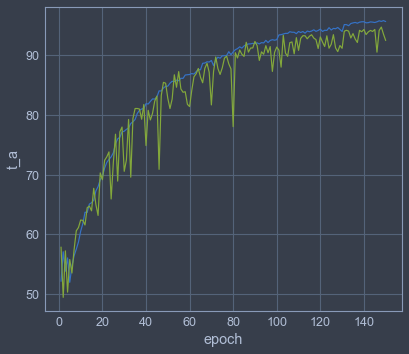

In [29]:
sns.lineplot(x='epoch',y='t_a', data=pd_a)
sns.lineplot(x='epoch',y='v_a', data=pd_a)

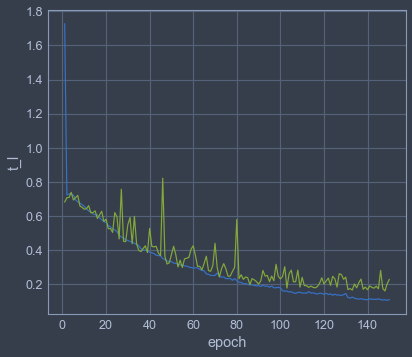

In [30]:
sns.lineplot(x='epoch',y='t_l',data=pd_l)
sns.lineplot(x='epoch',y='v_l',data=pd_l)